In [1]:
# TODO: describe SSD model
import keras.backend as K
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import GlobalAveragePooling2D
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import Reshape
from keras.layers import ZeroPadding2D
from keras.layers import concatenate
from keras.models import Model

from ssd_layers import Normalize
from ssd_layers import PriorBox

Using TensorFlow backend.


In [2]:
class SSD300:
    
    def __init__(self, input_shape, num_classes=20):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.input_layer = Input(shape=input_shape)
        self.img_size = tuple(self.input_shape[1::-1])
        
    def model(self):
        self._basic_layer()
        # only conv4_3 layer for loc, conf and priorbox
        self._norm_layer()
        # three core layers
        self._loc_layer()
        self._conf_layer()
        self._prior_box_layer()
        
        mbox_loc = concatenate([self.conv4_3_norm_mbox_loc_flat,
                               self.fc7_mbox_loc_flat,
                               self.conv6_2_mbox_loc_flat,
                               self.conv7_2_mbox_loc_flat,
                               self.conv8_2_mbox_loc_flat,
                               self.pool6_mbox_loc_flat], axis=1, name='mbox_loc')
        
        mbox_conf = concatenate([self.conv4_3_norm_mbox_conf_flat,
                                self.fc7_mbox_conf_flat,
                                self.conv6_2_mbox_conf_flat,
                                self.conv7_2_mbox_conf_flat,
                                self.conv8_2_mbox_conf_flat,
                                self.pool6_mbox_conf_flat], axis=1, name='mbox_conf')
        
        mbox_priorbox = concatenate([self.conv4_3_norm_mbox_priorbox,
                                    self.fc7_mbox_priorbox,
                                    self.conv6_2_mbox_priorbox,
                                    self.conv7_2_mbox_priorbox,
                                    self.conv8_2_mbox_priorbox,
                                    self.pool6_mbox_priorbox], axis=1, name='mbox_priorbox')
        
        if hasattr(mbox_loc, '_keras_shape'):
            num_boxes = mbox_loc._keras_shape[-1] // 4
        elif hasattr(mbox_loc, 'int_shape'):
            num_boxes = K.int_shape(mbox_loc)[-1] // 4
        
        mbox_loc = Reshape((num_boxes, 4), name='mbox_loc_final')(mbox_loc)
        
        mbox_conf = Reshape((num_boxes, self.num_classes), name='mbox_conf_logits')(mbox_conf)
        mbox_conf = Activation('softmax', name='mbox_conf_final')(mbox_conf)
        
        predictions = concatenate([mbox_loc, mbox_conf, mbox_priorbox], axis=2, name='predictions')
        
        model = Model(inputs=self.input_layer, outputs=predictions)
        return model
    
    def _norm_layer(self):
        self.conv4_3_norm = Normalize(20, name='conv4_3_norm')(self.conv4_3)
    
    def _loc_layer(self):
        # conv4_3
        num_priors = 3
        conv4_3_norm_mbox_loc = Conv2D(num_priors * 4, (3, 3), name='conv4_3_norm_mbox_loc', padding='same')(self.conv4_3_norm)
        self.conv4_3_norm_mbox_loc_flat = Flatten(name='conv4_3_norm_mbox_loc_flat')(conv4_3_norm_mbox_loc)
        
        # fc 7
        num_priors = 6
        fc7_mbox_loc = Conv2D(num_priors * 4, (3, 3), name='fc7_mbox_loc', padding='same')(self.fc7)
        self.fc7_mbox_loc_flat = Flatten(name='fc7_mbox_loc_flat')(fc7_mbox_loc)
    
        # conv6_2
        conv6_2_mbox_loc = Conv2D(num_priors * 4, (3, 3), name='conv6_2_mbox_loc', padding='same')(self.conv6_2)
        self.conv6_2_mbox_loc_flat = Flatten(name='conv6_2_mbox_loc_flat')(conv6_2_mbox_loc)
        
        # conv7_2
        conv7_2_mbox_loc = Conv2D(num_priors * 4, (3, 3), name='conv7_2_mbox_loc', padding='same')(self.conv7_2)
        self.conv7_2_mbox_loc_flat = Flatten(name='conv7_2_mbox_loc_flat')(conv7_2_mbox_loc)
        
        # conv8_2
        conv8_2_mbox_loc = Conv2D(num_priors * 4, (3, 3), name='conv8_2_mbox_loc', padding='same')(self.conv8_2)
        self.conv8_2_mbox_loc_flat = Flatten(name='conv8_2_mbox_loc_flat')(conv8_2_mbox_loc)
        
        # pool6
        self.pool6_mbox_loc_flat = Dense(num_priors * 4, name='pool6_mbox_loc_flat')(self.pool6)
        
    def _conf_layer(self):
        if self.num_classes != 21:
            alias = '_{}'.format(self.num_classes)
        else:
            alias = ''
        
        # conv4_3
        num_priors = 3
        name = 'conv4_3_norm_mbox_conf' + alias
        conv4_3_norm_mbox_conf = Conv2D(num_priors * self.num_classes, (3, 3), name=name, padding='same')(self.conv4_3_norm)
        self.conv4_3_norm_mbox_conf_flat = Flatten(name='conv4_3_norm_mbox_conf_flat')(conv4_3_norm_mbox_conf)
    
        # fc7
        num_priors = 6
        name = 'fc7_mbox_conf' + alias
        fc7_mbox_conf = Conv2D(num_priors * self.num_classes, (3, 3), padding='same', name=name)(self.fc7)
        self.fc7_mbox_conf_flat = Flatten(name='fc7_mbox_conf_flat')(fc7_mbox_conf)
        
        # conv6_2
        name = 'conv6_2_mbox_conf' + alias
        conv6_2_mbox_conf = Conv2D(num_priors * self.num_classes, (3, 3), padding='same', name=name)(self.conv6_2)
        self.conv6_2_mbox_conf_flat = Flatten(name='conv6_2_mbox_conf_flat')(conv6_2_mbox_conf)
        
        # conv7_2
        name = 'conv7_2_mbox_conf' + alias
        conv7_2_mbox_conf = Conv2D(num_priors * self.num_classes, (3, 3), padding='same', name=name)(self.conv7_2)
        self.conv7_2_mbox_conf_flat = Flatten(name='conv7_2_mbox_conf_flat')(conv7_2_mbox_conf)
        
        # conv8_2
        name = 'conv8_2_mbox_conf' + alias
        conv8_2_mbox_conf = Conv2D(num_priors * self.num_classes, (3, 3), padding='same', name=name)(self.conv8_2)
        self.conv8_2_mbox_conf_flat = Flatten(name='conv8_2_mbox_conf_flat')(conv8_2_mbox_conf)
        
        # pool6
        name = 'pool6_mbox_conf_flat' + alias
        self.pool6_mbox_conf_flat = Dense(num_priors * self.num_classes, name=name)(self.pool6)
        
    def _prior_box_layer(self):
        # conv4_3
        self.conv4_3_norm_mbox_priorbox = PriorBox(self.img_size, 30.0, name='conv4_3_norm_mbox_priorbox', 
                                              aspect_ratios=[2], variances=[0.1, 0.1, 0.2, 0.2])(self.conv4_3_norm)
        # fc7
        self.fc7_mbox_priorbox = PriorBox(self.img_size, 60.0, name='fc7_mbox_priorbox', max_size=114.0, 
                                          aspect_ratios=[2, 3], variances=[0.1, 0.1, 0.2, 0.2])(self.fc7)
        
        # conv6_2
        self.conv6_2_mbox_priorbox = PriorBox(self.img_size, 114.0, max_size=168.0, 
                                              aspect_ratios=[2, 3], variances=[0.1, 0.1, 0.2, 0.2], name='conv6_2_mbox_priorbox')(self.conv6_2)
        
        # conv7_2
        self.conv7_2_mbox_priorbox = PriorBox(self.img_size, 168.0, max_size=222.0, 
                                              aspect_ratios=[2, 3], variances=[0.1, 0.1, 0.2, 0.2], name='conv7_2_mbox_priorbox')(self.conv7_2)
        
        # conv8_2
        self.conv8_2_mbox_priorbox = PriorBox(self.img_size, 222.0, max_size=276.0, 
                                              aspect_ratios=[2, 3], variances=[0.1, 0.1, 0.2, 0.2], name='conv8_2_mbox_priorbox')(self.conv8_2)
        
        # pool6
        if K.image_dim_ordering() == 'tf':
            target_shape = (1, 1, 256)
        else:
            target_shape = (256, 1, 1)
        pool6_reshaped = Reshape(target_shape, name='pool6_reshaped')(self.pool6)
        self.pool6_mbox_priorbox = PriorBox(self.img_size, 276.0, max_size=330.0, aspect_ratios=[2, 3], variances=[0.1, 0.1, 0.2, 0.2], name='pool6_mbox_priorbox')(pool6_reshaped)
        
    def _basic_layer(self):
        # conv 1
        conv1_1 = Conv2D(64, (3, 3), name='conv1_1', padding='same', activation='relu')(self.input_layer)
        conv1_2 = Conv2D(64, (3, 3), name='conv1_2', padding='same', activation='relu')(conv1_1)
        pool1 = MaxPooling2D(name='pool1', pool_size=(2, 2), strides=(2, 2), padding='same')(conv1_2)
        
        # conv 2
        conv2_1 = Conv2D(128, (3, 3), name='conv2_1', padding='same', activation='relu')(pool1)
        conv2_2 = Conv2D(128, (3, 3), name='conv2_2', padding='same', activation='relu')(conv2_1)
        pool2 = MaxPooling2D(name='pool2', pool_size=(2, 2), strides=(2, 2), padding='same')(conv2_2)
        
        # conv 3
        conv3_1 = Conv2D(256, (3, 3), name='conv3_1', padding='same', activation='relu')(pool2)
        conv3_2 = Conv2D(256, (3, 3), name='conv3_2', padding='same', activation='relu')(conv3_1)
        conv3_3 = Conv2D(256, (3, 3), name='conv3_3', padding='same', activation='relu')(conv3_2)
        pool3 = MaxPooling2D(name='pool3', pool_size=(2, 2), strides=(2, 2), padding='same')(conv3_3)
        
        # conv 4 [we need conv4_3]
        conv4_1 = Conv2D(512, (3, 3), name='conv4_1', padding='same', activation='relu')(pool3)
        conv4_2 = Conv2D(512, (3, 3), name='conv4_2', padding='same', activation='relu')(conv4_1)
        self.conv4_3 = Conv2D(512, (3, 3), name='conv4_3', padding='same', activation='relu')(conv4_2)
        pool4 = MaxPooling2D(name='pool4', pool_size=(2, 2), strides=(2, 2), padding='same')(self.conv4_3)
        
        # conv 5
        conv5_1 = Conv2D(512, (3, 3), name='conv5_1', padding='same', activation='relu')(pool4)
        conv5_2 = Conv2D(512, (3, 3), name='conv5_2', padding='same', activation='relu')(conv5_1)
        conv5_3 = Conv2D(512, (3, 3), name='conv5_3', padding='same', activation='relu')(conv5_2)
        pool5 = MaxPooling2D(name='pool5', pool_size=(3, 3), strides=(1, 1), padding='same')(conv5_3)
        
        # fc 6
        # 'dilation_rate' means skip how much pixels in feature map.
        fc6 = Conv2D(1024, (3, 3), name='fc6', dilation_rate=(6, 6), padding='same', activation='relu')(pool5)
        
        # fc 7 [we need fc7]
        self.fc7 = Conv2D(1024, (1, 1), name='fc7', padding='same', activation='relu')(fc6)
        
        # conv 6 [we need conv6_2]
        conv6_1 = Conv2D(256, (1, 1), name='conv6_1', padding='same', activation='relu')(self.fc7)
        self.conv6_2 = Conv2D(512, (3, 3), name='conv6_2', strides=(2, 2), padding='same', activation='relu')(conv6_1)
        
        # conv 7 [we need conv7_2]
        conv7_1 = Conv2D(128, (1, 1), name='conv7_1', padding='same', activation='relu')(self.conv6_2)
        conv7_1z = ZeroPadding2D(name='conv7_1z')(conv7_1)
        self.conv7_2 = Conv2D(256, (3, 3), name='conv7_2', padding='valid', strides=(2, 2), activation='relu')(conv7_1z)
        
        # conv 8 [we need conv8_2]
        conv8_1 = Conv2D(128, (1, 1), name='conv8_1', padding='same', activation='relu')(self.conv7_2)
        self.conv8_2 = Conv2D(256, (3, 3), name='conv8_2', padding='same', strides=(2, 2), activation='relu')(conv8_1)
        
        # last pool [we need this]
        self.pool6 = GlobalAveragePooling2D(name='pool6')(self.conv8_2)

model = SSD300((300, 300, 3), num_classes=21)
model = model.model()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 300, 300, 3)   0                                            
____________________________________________________________________________________________________
conv1_1 (Conv2D)                 (None, 300, 300, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
conv1_2 (Conv2D)                 (None, 300, 300, 64)  36928       conv1_1[0][0]                    
____________________________________________________________________________________________________
pool1 (MaxPooling2D)             (None, 150, 150, 64)  0           conv1_2[0][0]                    
___________________________________________________________________________________________

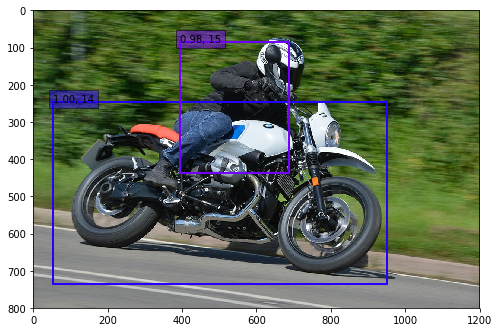

In [3]:
# Test it
import pickle
from ssd_utils import BBoxUtility
from utils import demo
%matplotlib inline

priors = pickle.load(open('prior_boxes_ssd300.pkl', 'rb'))
bbox_util = BBoxUtility(21, priors)
model.load_weights('data/weights_SSD300.hdf5', by_name=True)

img_path='./pics/my-test-motor-man.jpg'
demo.demo(model, img_path, bbox_util)